# 02: Time Series Classification

To determine a product forecastability, we apply two coefficients:

- the Average Demand Interval (ADI). It measures the demand regularity in time by computing the average interval between two demands.
- the square of the Coefficient of Variation (CV²). It measures the variation in quantities.

Based on these 2 dimensions, the literature classifies the demand profiles into 4 different categories:

- **Smooth demand** (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. 
- **Intermittent demand** (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.
- **Erratic demand** (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.
- **Lumpy demand** (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.

In [ ]:
from utils.database import * 
from utils.utils import *
from utils.preprocessing import *
from utils.plotting import *
from utils.metrics import *

In [37]:
# make training set 
train_index = 550
STEPS = 28

agg_levels = {
    'level_2': ['nome_top_parent']
}

daily_data = fetch_target()
daily_data = pivot_data(daily_data, "ettdeb")
train_agg = aggregation(daily_data, 
                        agg_levels=agg_levels).T
train_agg = reconcile_date(train_agg)
#train_agg = train_agg.reset_index(drop = False)
#train_agg = train_agg.drop("date", axis = 1)
train_agg

Connected to the MySQL database


c:\Users\Miguel\Desktop\Catolica Data Analytics\CPBS-TS-2\utils\database.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_data = pd.read_sql(sql_query, connection)


Connection closed


,Artigos Decorativos,Bases e Floreiras,Casa,Flores,Fontes,Frutos e Vegetais,Natal,Plantas,Tufos e Folhagens,Árvores e Arbustos
date,,,,,,,,,,
2018-01-04,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,3034.5612
2018-01-05,0.0,52.8,0.0,63.55,0.0,65.86,0.0,512.425,0.0,1536.6440
2018-01-06,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,0.0000
2018-01-07,0.0,0.0,0.0,0.00,0.0,0.00,170.5,0.000,0.0,449.9050
2018-01-08,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
2019-12-26,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,0.0000
2019-12-27,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,0.0000
2019-12-28,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.0,0.0000


In [1]:
train_agg.columns

NameError: name 'train_agg' is not defined

In [55]:
def adi_func_interval(series):
    periods = []
    ts = np.trim_zeros(series.values, 'f')
    p_idx = np.flatnonzero(ts) + 1
    p = np.diff(p_idx)
    periods.extend(p)

    q = [0.5, 0.75, 0.95, 0.99]
    periods = np.array(periods)
    q_results = np.quantile(periods, q)
    for i in range(len(q)):
        print(f'Quantile: {q[i]}, Bucket Size: {q_results[i]}')
    print(f'\nMax interval: {periods.max()}')
    print(f'\nMean interval: {np.mean(periods)}')
    return np.mean(periods)

def adi_func(series):
    num_zeros = series.eq(0).sum() 
    adi = len(series)/num_zeros
    print(f"ADI: {adi}")
    return adi

def cv_sqr_func(series):
    series_mean = series.mean()
    series_std = series.std()
    
    # Compute Coefficient of Variation (CV)
    cv = (series_std / series_mean)**2
    print(f'CV: {cv}')
    return cv

def classify_demand(adi, cv_squared):
    if adi < 1.32 and cv_squared < 0.49:
        return "Smooth demand"
    elif adi >= 1.32 and cv_squared < 0.49:
        return "Intermittent demand"
    elif adi < 1.32 and cv_squared >= 0.49:
        return "Erratic demand"
    else:
        return "Lumpy demand"

Quantile: 0.5, Bucket Size: 16.0
Quantile: 0.75, Bucket Size: 41.5
Quantile: 0.95, Bucket Size: 104.90000000000006
Quantile: 0.99, Bucket Size: 164.1799999999999

Max interval: 179

Mean interval: 33.15
CV: 128.66565113164546
ADI: 1.0297872340425531
Lumpy demand
Quantile: 0.5, Bucket Size: 18.0
Quantile: 0.75, Bucket Size: 27.5
Quantile: 0.95, Bucket Size: 78.39999999999998
Quantile: 0.99, Bucket Size: 93.87999999999998

Max interval: 97

Mean interval: 24.51851851851852
CV: 52.046343159654164
ADI: 1.0401146131805157
Lumpy demand
Quantile: 0.5, Bucket Size: 54.0
Quantile: 0.75, Bucket Size: 61.5
Quantile: 0.95, Bucket Size: 101.59999999999997
Quantile: 0.99, Bucket Size: 113.11999999999998

Max interval: 116

Mean interval: 54.42857142857143
CV: 129.96575825763296
ADI: 1.011142061281337
Lumpy demand
Quantile: 0.5, Bucket Size: 3.0
Quantile: 0.75, Bucket Size: 6.0
Quantile: 0.95, Bucket Size: 15.0
Quantile: 0.99, Bucket Size: 19.0

Max interval: 21

Mean interval: 4.7465753424657535
CV:

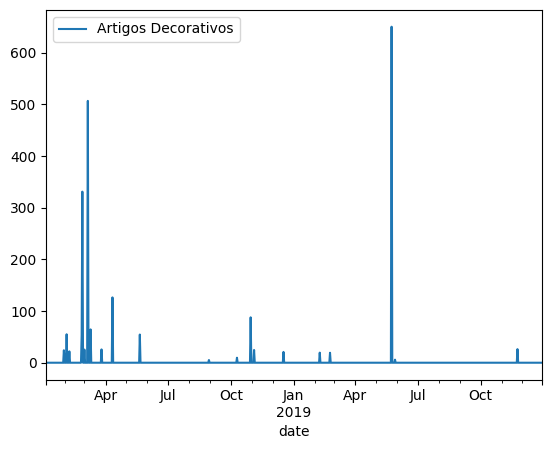

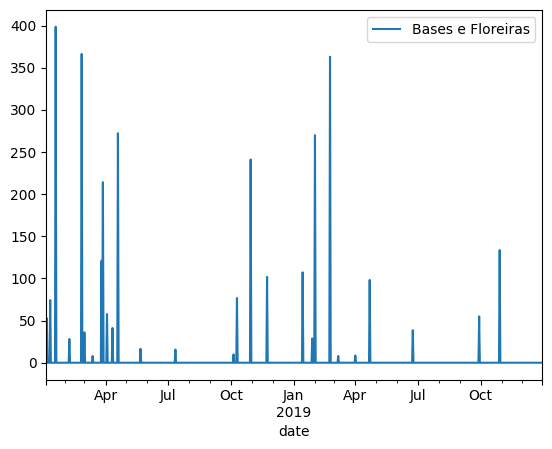

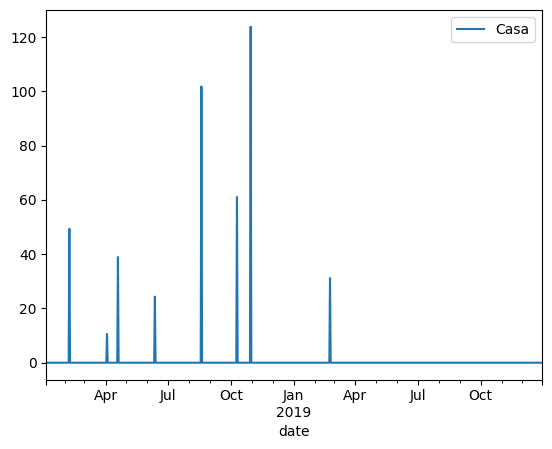

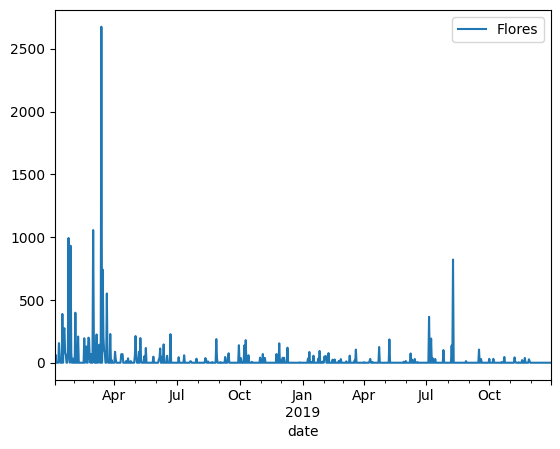

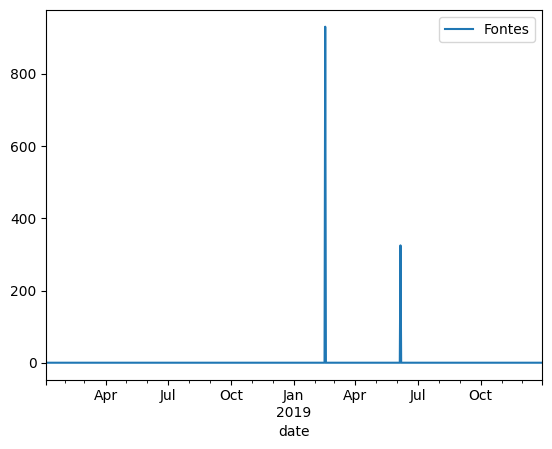

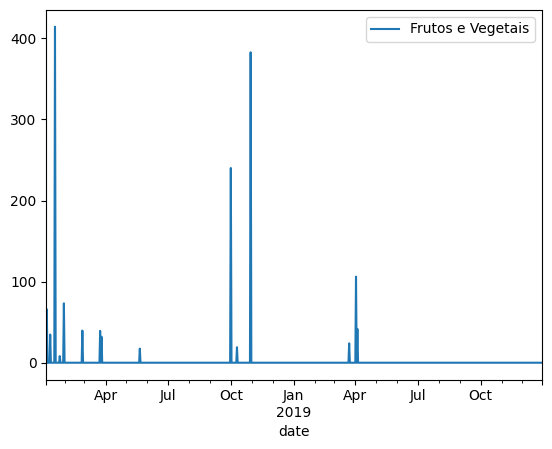

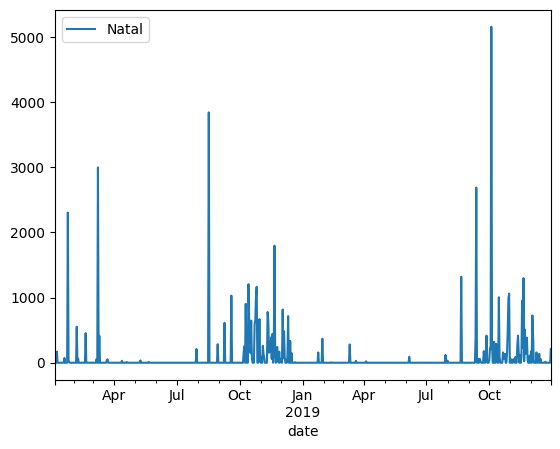

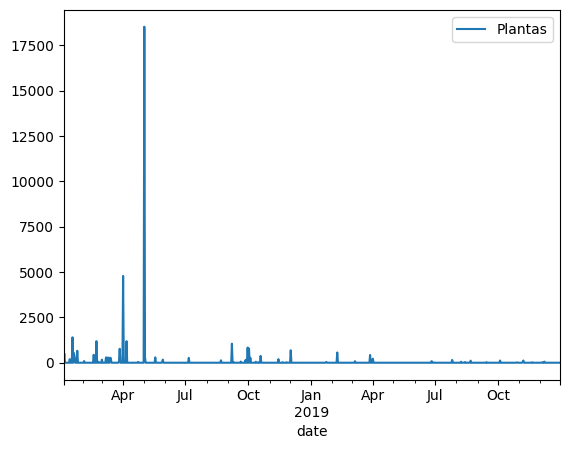

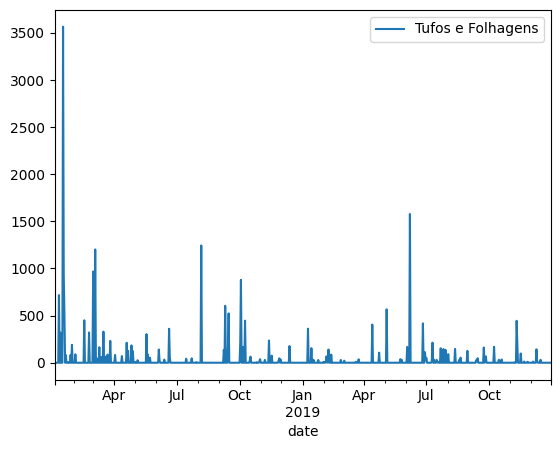

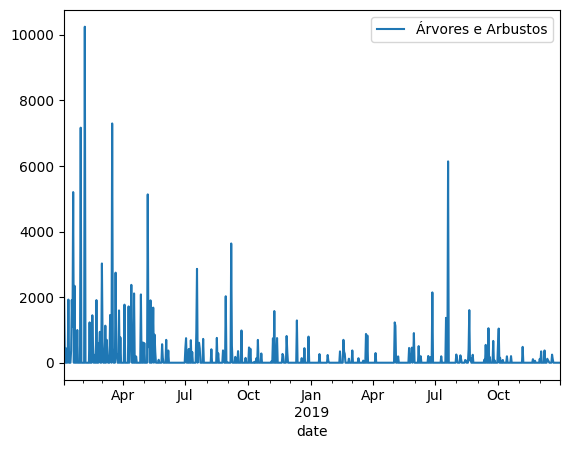

In [57]:
for column in train_agg.columns:
    adi = adi_func_interval(train_agg[column])
    cv = cv_sqr_func(train_agg[column])
    adi_func(train_agg[column])
    print(classify_demand(adi, cv))
    train_agg[[column]].plot(kind = "line")